# <b>SQL Server Architecture</b>


## <u>Modelos de Transação no SQL Server</u>

O SQL Server executa transações nos seguintes modelos:<br>
    <ul>- <B>IMPLICITA<BR>
    - EXPLICITA<BR></B></ul>

In [ ]:
--Transação IMPLICITA
UPDATE Badges SET Name = 'Student' WHERE Id = 82946 --OK
UPDATE Badges SET Name = 'Master'  WHERE Id = 82947 --ERRO
UPDATE Badges SET Name = 'Novice'  WHERE Id = 82949 --OK

--Transação EXPLICITA
BEGIN TRANSACTION
	UPDATE Badges SET Name = 'Student' WHERE Id = 82950
	UPDATE Badges SET Name = 'Master'  WHERE Id = 82951
	UPDATE Badges SET Name = 'Novice'  WHERE Id = 82952

	IF @@ERROR <> 0
		COMMIT
	ELSE
		ROLLBACK

O uso do hint **WITH (NOLOCK)** pode ocasionar os seguintes cenários:

**\- Leituras Sujas  
\- Leituras fantasmas**

In [ ]:
SELECT
	*
FROM
	Badges WITH (NOLOCK)
WHERE
	Id IN (82950,82951,82952)

Monitorando os <b>locks</b> de transação realizados nos objetos de um banco de dados

In [ ]:
SELECT
	request_session_id as session_id,
	CASE 
		WHEN o.name IS NULL THEN 'INDX Row' 
	ELSE o.name END as table_name, 
	resource_associated_entity_id as table_id, 
	request_mode, 
	request_type, 
	request_status, 
	request_owner_type, 
	request_owner_id, 
	resource_type, 
	resource_subtype, 
	resource_database_id 
FROM 
	sys.dm_tran_locks t 
LEFT OUTER JOIN 
	sys.sysobjects o ON 
	t.resource_associated_entity_id = o.id
where 
	request_mode in ('X','IX') 
and 
	resource_type in ('OBJECT')--, 'KEY')  
and 
	resource_database_id = DB_ID('StackOverflow2013') 
ORDER BY 
	request_session_id, request_mode DESC

## <u>SQL Server Network Interface (SNI)</u>
Verificando quais protocolos estão habilitados na instância

In [2]:
SELECT 'Named Pipes' AS [Protocol], iif(value_data = 1, 'Yes', 'No') AS isEnabled
FROM sys.dm_server_registry
WHERE registry_key LIKE '%np' AND value_name = 'Enabled'
UNION
SELECT 'Shared Memory', iif(value_data = 1, 'Yes', 'No')
FROM sys.dm_server_registry
WHERE registry_key LIKE '%sm' AND value_name = 'Enabled'
UNION
SELECT 'TCP/IP', iif(value_data = 1, 'Yes', 'No')
FROM sys.dm_server_registry
WHERE registry_key LIKE '%tcp' AND value_name = 'Enabled'

(3 rows affected)

Total execution time: 00:00:00.018

Protocol,isEnabled
Named Pipes,No
Shared Memory,Yes
TCP/IP,No


## <u>Tabular Data Stream (TDS)</u>
1) Conectar na máquina virtual no Azure<br>
2) Iniciar o WireShark<br>
3) Filtrar somente os eventos de TDS<br>
4) Conectar no servidor utilizando o SSMS local<br>
5) Monitorar os pacotes TDS sendo enviados ao servidor<br>


In [5]:
USE DBTeste
GO
SELECT * FROM Cliente

Commands completed successfully.

(3 rows affected)

Total execution time: 00:00:00.062

CodCli,NomeCli
1,aaaaaaaa
2,bbbbbbb
3,ccccccc


## <u>Plan Cache</u>
Listar os planos de execução em cache

In [9]:
SELECT 
    *
FROM
    sys.dm_exec_cached_plans
CROSS APPLY
    sys.dm_exec_sql_text(plan_handle)
WHERE  
    text LIKE '%Cliente%'

(2 rows affected)

Total execution time: 00:00:00.178

bucketid,refcounts,usecounts,size_in_bytes,memory_object_address,cacheobjtype,objtype,plan_handle,pool_id,parent_plan_handle,dbid,objectid,number,encrypted,text
16948,2,2,65536,0x000001C3F7D28060,Compiled Plan,Adhoc,0x060005003470C80AE0F962F8C301000001000000000000000000000000000000000000000000000000000000,2,NULL,5,NULL,NULL,0,SELECT * FROM sys.dm_exec_cached_plans CROSS APPLY sys.dm_exec_sql_text(plan_handle) WHERE text LIKE '%Cliente%'
36166,2,2,40960,0x000001C3F8EEA060,Compiled Plan,Adhoc,0x06000500DC28C4181026E4FAC301000001000000000000000000000000000000000000000000000000000000,2,NULL,5,NULL,NULL,0,SELECT * FROM Cliente


## <u>Query Optimizer</u>
- Baseado em custo <br>
- Otimização em estágios (Multi-Stage)<br>
    - Fase 0 - <B>TRIVIAL PLAN</b>
    - Fase 1 - <b>QUICK PLAN</b>
    - Fase 2 - <b>FULL PLAN</b>

In [ ]:
--Query com plano de execução TRIVIAL
SELECT
	*
FROM
	Badges
WHERE
	Id = 82950


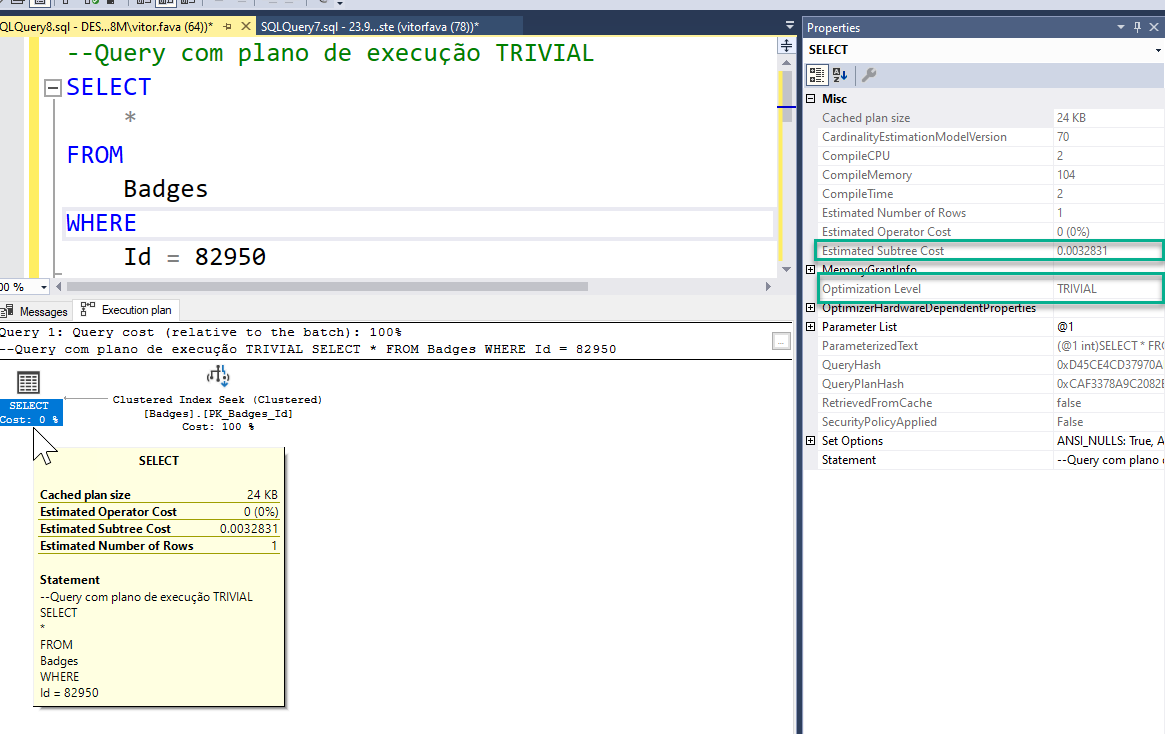

In [ ]:
--Query com plano de execução FULL
SELECT
	* 
FROM
	Users U
INNER JOIN
	Badges B
ON
	U.Id = B.UserId
WHERE
	U.Id = 4591

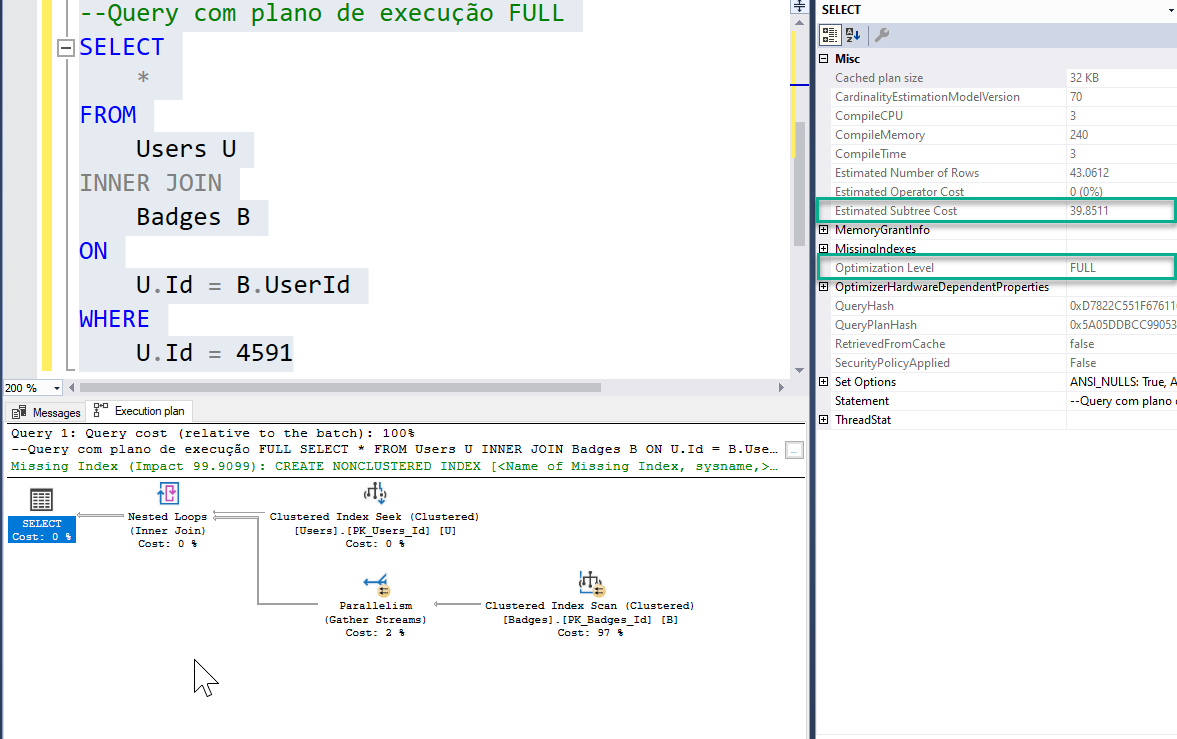

## <u>Buffer Pool</u>


A primeira leitura da tabela <b>Users</b> precisará carregar páginas do disco e por isso <b>executará operações de leitura física</b>

In [ ]:
SET STATISTICS IO ON
SELECT
	*
FROM
	Users

/*(2465713 rows affected)
Table 'Users'. Scan count 1, logical reads 44530, physical reads 3, 
page server reads 0, read-ahead reads 44510, page server read-ahead reads 0, 
lob logical reads 216, lob physical reads 9, lob page server reads 0, lob read-ahead reads 0, 
lob page server read-ahead reads 0.*/


As próximas operações de leitura da tabela <b>Users</b> serão direcionadas para o <b>Buffer Cache (Data Cache)</b> e <b>executarão operações de leitura lógica</b>

In [ ]:
SET STATISTICS IO ON
SELECT
	*
FROM
	Users

/*(2465713 rows affected)
Table 'Users'. Scan count 1, logical reads 44530, physical reads 0, page server reads 0, read-ahead reads 0, 
page server read-ahead reads 0, lob logical reads 216, lob physical reads 0, lob page server reads 0, lob read-ahead reads 0, 
lob page server read-ahead reads 0.*/

Listando as páginas de dados que foram carregadas para o <b>buffer cache</b>

In [1]:
--Listar a quantidade de páginas existentes em cache
SELECT 
	count(*)*8/1024 AS 'Cached Size (MB)',
	CASE 
		database_id
	WHEN 32767 THEN 'ResourceDb'
	ELSE 
		db_name(database_id)
	END AS 'Database'
FROM 
	sys.dm_os_buffer_descriptors
GROUP BY 
	db_name(database_id),database_id
ORDER BY 
	'Cached Size (MB)' DESC

(14 rows affected)

Total execution time: 00:00:00.154

Cached Size (MB),Database
238,StackOverflow2013_SSD
18,ResourceDb
2,AdventureWorks2012
2,master
1,AdventureWorks2012_SSD
1,tempdb
1,msdb
1,StackOverflow2013
0,model
0,DBteste


Listando as páginas de dados que já foram <b>alteradas (dirty pages)</b> no <b>buffer cache</b>

In [ ]:
--Listando dirty pages
SELECT 
	db_name(database_id) AS 'Database',
	count(page_id) AS 'Dirty Pages'
FROM 
	sys.dm_os_buffer_descriptors
WHERE 
	is_modified =1
GROUP BY 
	db_name(database_id)
ORDER BY 
	count(page_id) DESC

## <u>Page Life Expectancy - PLE</u>

Verifica o <b>PLE</b> da instância de banco de dados SQL Server<br>
O <b>valor mínimo</b> recomendado é de <b>1000 segundos</b>

In [8]:
--Verifica o PLE de dentro do SQL Server
SELECT
ple.[Node]
,LTRIM(STR([PageLife_S]/3600))+':'+REPLACE(STR([PageLife_S]%3600/60,2),SPACE(1),'0')+':'+REPLACE(STR([PageLife_S]%60,2),SPACE(1),'0') [PageLife]
,ple.[PageLife_S]
,dp.[DatabasePages] [BufferPool_Pages]
,CONVERT(DECIMAL(15,3),dp.[DatabasePages]*0.0078125) [BufferPool_MiB] ,CONVERT(DECIMAL(15,3),dp.[DatabasePages]*0.0078125/[PageLife_S]) [BufferPool_MiB_S]
FROM
(
SELECT [instance_name] [node],[cntr_value] [PageLife_S] FROM sys.dm_os_performance_counters
WHERE [counter_name] = 'Page life expectancy'
) ple
INNER JOIN
(
SELECT [instance_name] [node],[cntr_value] [DatabasePages] FROM sys.dm_os_performance_counters
WHERE [counter_name] = 'Database pages'
) dp ON ple.[node] = dp.[node]

(2 rows affected)

Total execution time: 00:00:00.005

Node,PageLife,PageLife_S,BufferPool_Pages,BufferPool_MiB,BufferPool_MiB_S
,0:00:34,34,80510,628.984,18.500
000,0:00:34,34,80510,628.984,18.500


## <u>Arquitetura do transaction log</u>

A criação de **VLF (arquivos de log virtuais)** segue este método:

- Se o próximo **crescimento** for **menor** que **1/8** do tamanho físico do **log atual**, crie **1 VLF** que abranja o tamanho do crescimento (começando com SQL Server 2014 (12.x))
- Se o próximo **crescimento** for **maior que 1/8** do tamanho atual do log, use o método pré-2014:
    - Se o **crescimento** for **menor que 64 MB**, crie **4 VLFs** que abranjam o tamanho do crescimento (**por exemplo, para um crescimento de 1 MB, crie quatro VLFs de 256 KB**)
    - Se o **crescimento** for de **64 MB a 1 GB**, crie **8 VLFs** que abranjam o tamanho do crescimento (**por exemplo, para um crescimento de 512 MB, crie oito VLFs de 64 MB**)
    - Se o **crescimento** for **maior que 1 GB**, crie **16 VLFs** que abranjam o tamanho do crescimento (**por exemplo, para um crescimento de 8 GB, crie dezesseis VLFs de 512 MB**)

![Resultado de imagem para transaction log architecture](https://www.sqlservercentral.com/wp-content/uploads/legacy/120faa40f50177165acf53980acb8e700a8afd53/10861.png)

In [ ]:
--Verificar os VLFs existentes no banco de dados

--A partir SQL Server 2016
SELECT * FROM sys.dm_db_log_info (DB_ID()) 

--Todas as versões do SQL Server
DBCC LOGINFO
GO

SELECT 
    [name], s.database_id,
    COUNT(l.database_id) AS 'VLF Count',
    SUM(vlf_size_mb) AS 'VLF Size (MB)',
    SUM(CAST(vlf_active AS INT)) AS 'Active VLF',
    SUM(vlf_active*vlf_size_mb) AS 'Active VLF Size (MB)',
    COUNT(l.database_id)-SUM(CAST(vlf_active AS INT)) AS 'In-active VLF',
    SUM(vlf_size_mb)-SUM(vlf_active*vlf_size_mb) AS 'In-active VLF Size (MB)'
FROM 
    sys.databases s
CROSS APPLY 
    sys.dm_db_log_info(s.database_id) l
GROUP BY 
    [name], s.database_id
ORDER BY '
    VLF Count' DESC
GO

In [ ]:
-- Script para corrigir o número de VLF's 
--
SET NOCOUNT ON;

DECLARE @query VARCHAR(1000), @dbname VARCHAR(255), @count int, @usedlogsize bigint, @logsize bigint
DECLARE @sqlcmd NVARCHAR(1000), @sqlparam NVARCHAR(100), @filename VARCHAR(255), @i int, @recmodel NVARCHAR(128)
DECLARE @potsize int, @n_iter int, @n_iter_final int, @initgrow int, @n_init_iter int, @bckpath NVARCHAR(255)
DECLARE @majorver smallint, @minorver smallint, @build smallint

CREATE TABLE #loginfo (dbname varchar(100), num_of_rows int, used_logsize_MB DECIMAL(20,1))

DECLARE @tblvlf TABLE (dbname varchar(100), 
	Actual_log_size_MB DECIMAL(20,1), 
	Potential_log_size_MB DECIMAL(20,1), 
	Actual_VLFs int, 
	Potential_VLFs int, 
	Growth_iterations int,
	Log_Initial_size_MB DECIMAL(20,1), 
	File_autogrow_MB DECIMAL(20,1))
	
SELECT TOP 1 @bckpath = REVERSE(RIGHT(REVERSE(physical_device_name), LEN(physical_device_name)-CHARINDEX('\',REVERSE(physical_device_name),0))) FROM msdb.dbo.backupmediafamily WHERE device_type = 2

SELECT @majorver = (@@microsoftversion / 0x1000000) & 0xff, @minorver = (@@microsoftversion / 0x10000) & 0xff, @build = @@microsoftversion & 0xffff
 
--DECLARE csr CURSOR FAST_FORWARD FOR SELECT name FROM master..sysdatabases WHERE dbid > 4 AND DATABASEPROPERTYEX(name,'status') = 'ONLINE' AND DATABASEPROPERTYEX(name,'Updateability') = 'READ_WRITE' AND name <> 'tempdb' AND name <> 'ReportServerTempDB'
DECLARE csr CURSOR FAST_FORWARD FOR SELECT name FROM master.sys.databases WHERE is_read_only = 0 AND state = 0 AND database_id <> 2;
OPEN csr
FETCH NEXT FROM csr INTO @dbname
WHILE (@@FETCH_STATUS <> -1)
BEGIN
	CREATE TABLE #log_info (recoveryunitid int NULL,
	fileid tinyint,
	file_size bigint,
	start_offset bigint,
	FSeqNo int,
	[status] tinyint,
	parity tinyint,
	create_lsn numeric(25,0))

	SET @query = 'DBCC LOGINFO (' + '''' + @dbname + ''') WITH NO_INFOMSGS'
	IF @majorver < 11
	BEGIN
		INSERT INTO #log_info (fileid, file_size, start_offset, FSeqNo, [status], parity, create_lsn)
		EXEC (@query)
	END
	ELSE
	BEGIN
		INSERT INTO #log_info (recoveryunitid, fileid, file_size, start_offset, FSeqNo, [status], parity, create_lsn)
		EXEC (@query)
	END
	SET @count = @@ROWCOUNT
	SET @usedlogsize = (SELECT (MIN(l.start_offset) + SUM(CASE WHEN l.status <> 0 THEN l.file_size ELSE 0 END))/1024.00/1024.00 FROM #log_info l)
	DROP TABLE #log_info;
	INSERT #loginfo
	VALUES(@dbname, @count, @usedlogsize);
	FETCH NEXT FROM csr INTO @dbname
END

CLOSE csr
DEALLOCATE csr

PRINT '/* Generated on ' + CONVERT (VARCHAR, GETDATE()) + ' in ' + @@SERVERNAME + ' */' + CHAR(10)
	
DECLARE cshrk CURSOR FAST_FORWARD FOR SELECT dbname, num_of_rows FROM #loginfo 
WHERE num_of_rows >= 50 --My rule of thumb is 50 VLFs. Your mileage may vary.
ORDER BY dbname
OPEN cshrk
FETCH NEXT FROM cshrk INTO @dbname, @count
WHILE (@@FETCH_STATUS <> -1)
BEGIN
	SET @sqlcmd = 'SELECT @nameout = name, @logsizeout = (size*8)/1024 FROM [' + @dbname + '].dbo.sysfiles WHERE (64 & status) = 64'
	SET @sqlparam = '@nameout NVARCHAR(100) OUTPUT, @logsizeout bigint OUTPUT'
	EXEC sp_executesql @sqlcmd, @sqlparam, @nameout = @filename OUTPUT, @logsizeout = @logsize OUTPUT;
	PRINT '---------------------------------------------------------------------------------------------------------- '
	PRINT CHAR(13) + 'USE ' + QUOTENAME(@dbname) + ';'
	PRINT 'DBCC SHRINKFILE (N''' + @filename + ''', 1, TRUNCATEONLY);'
	PRINT '--'
	PRINT '-- CHECK: if the tlog file has shrunk with the following query:'
	PRINT 'SELECT name, (size*8)/1024 AS log_MB FROM [' + @dbname + '].dbo.sysfiles WHERE (64 & status) = 64'
	PRINT '--'
	SET @recmodel = CONVERT(NVARCHAR, DATABASEPROPERTYEX(@dbname,'Recovery'))
	IF @recmodel <> 'SIMPLE' 
	AND SERVERPROPERTY('EngineEdition') <> 8 -- This cannot be applied on Managed Instance
	BEGIN
		PRINT '-- If the log has not shrunk, you must backup the transaction log next.'
		PRINT '-- Repeat the backup and shrink process alternatively until you get the desired log size (about 1MB).'
		PRINT '--'
		PRINT '-- METHOD: Backup -> Shrink (repeat the backup and shrink process until the log has shrunk):'
		PRINT '--'
		PRINT '-- Create example logical backup device.' 
		PRINT 'USE master;' + CHAR(13) + 'EXEC sp_addumpdevice ''disk'', ''BckLog'', ''' + @bckpath + '\example_bck.trn'';'
		PRINT 'USE ' + QUOTENAME(@dbname) + ';'
		PRINT '-- Backup Log'
		PRINT 'BACKUP LOG ' + QUOTENAME(@dbname) + ' TO BckLog;'
		PRINT '-- Shrink'
		PRINT 'DBCC SHRINKFILE (N''' + @filename + ''', 1);'
		PRINT '--'
		PRINT '-- METHOD: Alter recovery model -> Shrink:'
		PRINT '-- NOTE: Because the database is in ' + @recmodel + ' recovery model, one alternative is to set it to SIMPLE to truncate the log, shrink it, and reset it to ' + @recmodel + '.'
		PRINT '-- NOTE2: This method of setting the recovery model to SIMPLE and back again WILL BREAK log chaining, and thus any log shipping or mirroring.'
		PRINT 'USE [master]; ' + CHAR(13) + 'ALTER DATABASE ' + QUOTENAME(@dbname) + ' SET RECOVERY SIMPLE;'
		PRINT 'USE ' + QUOTENAME(@dbname) + ';' + CHAR(13) + 'DBCC SHRINKFILE (N''' + @filename + ''', 1);'
		PRINT 'USE [master]; ' + CHAR(13) + 'ALTER DATABASE ' + QUOTENAME(@dbname) + ' SET RECOVERY ' + @recmodel + ';'
		PRINT '--'
		PRINT '-- CHECK: if the tlog file has shrunk with the following query:'
		PRINT 'SELECT name, (size*8)/1024 AS log_MB FROM [' + @dbname + '].dbo.sysfiles WHERE (64 & status) = 64'
	END
	ELSE
	BEGIN
		PRINT '-- If not, then proceed to the next step (it may be necessary to execute multiple times):'
		PRINT 'DBCC SHRINKFILE (N''' + @filename + ''', 1);'
		PRINT '-- CHECK: if the tlog file has shrunk with the following query:'
		PRINT 'SELECT name, (size*8)/1024 AS log_MB FROM [' + @dbname + '].dbo.sysfiles WHERE (64 & status) = 64'
	END

	-- We are growing in MB instead of GB because of known issue prior to SQL 2012.
	-- More detail here: http://www.sqlskills.com/BLOGS/PAUL/post/Bug-log-file-growth-broken-for-multiples-of-4GB.aspx
	-- and http://connect.microsoft.com/SQLServer/feedback/details/481594/log-growth-not-working-properly-with-specific-growth-sizes-vlfs-also-not-created-appropriately
	-- or https://connect.microsoft.com/SQLServer/feedback/details/357502/transaction-log-file-size-will-not-grow-exactly-4gb-when-filegrowth-4gb
	IF @majorver >= 11
	BEGIN
		SET @n_iter = (SELECT CASE WHEN @logsize <= 64 THEN 1
			WHEN @logsize > 64 AND @logsize < 256 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/256, 0)
			WHEN @logsize >= 256 AND @logsize < 1024 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/512, 0)
			WHEN @logsize >= 1024 AND @logsize < 4096 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/1024, 0)
			WHEN @logsize >= 4096 AND @logsize < 8192 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/2048, 0)
			WHEN @logsize >= 8192 AND @logsize < 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/4096, 0)
			WHEN @logsize >= 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/8192, 0)
			END)
		SET @potsize = (SELECT CASE WHEN @logsize <= 64 THEN 1*64
			WHEN @logsize > 64 AND @logsize < 256 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/256, 0)*256
			WHEN @logsize >= 256 AND @logsize < 1024 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/512, 0)*512
			WHEN @logsize >= 1024 AND @logsize < 4096 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/1024, 0)*1024
			WHEN @logsize >= 4096 AND @logsize < 8192 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/2048, 0)*2048
			WHEN @logsize >= 8192 AND @logsize < 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/4096, 0)*4096
			WHEN @logsize >= 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/8192, 0)*8192
			END)
	END
	ELSE
	BEGIN
		SET @n_iter = (SELECT CASE WHEN @logsize <= 64 THEN 1
			WHEN @logsize > 64 AND @logsize < 256 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/256, 0)
			WHEN @logsize >= 256 AND @logsize < 1024 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/512, 0)
			WHEN @logsize >= 1024 AND @logsize < 4096 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/1024, 0)
			WHEN @logsize >= 4096 AND @logsize < 8192 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/2048, 0)
			WHEN @logsize >= 8192 AND @logsize < 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/4000, 0)
			WHEN @logsize >= 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/8000, 0)
			END)
		SET @potsize = (SELECT CASE WHEN @logsize <= 64 THEN 1*64
			WHEN @logsize > 64 AND @logsize < 256 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/256, 0)*256
			WHEN @logsize >= 256 AND @logsize < 1024 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/512, 0)*512
			WHEN @logsize >= 1024 AND @logsize < 4096 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/1024, 0)*1024
			WHEN @logsize >= 4096 AND @logsize < 8192 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/2048, 0)*2048
			WHEN @logsize >= 8192 AND @logsize < 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/4000, 0)*4000
			WHEN @logsize >= 16384 THEN ROUND(CONVERT(FLOAT, ROUND(@logsize, -2))/8000, 0)*8000
			END)
	END
	
	-- If the proposed log size is smaller than current log, and also smaller than 4GB,
	-- and there is less than 512MB of diff between the current size and proposed size, add 1 grow.
	SET @n_iter_final = @n_iter
	IF @logsize > @potsize AND @potsize <= 4096 AND ABS(@logsize - @potsize) < 512
	BEGIN
		SET @n_iter_final = @n_iter + 1
	END
	-- If the proposed log size is larger than current log, and also larger than 50GB, 
	-- and there is less than 1GB of diff between the current size and proposed size, take 1 grow.
	ELSE IF @logsize < @potsize AND @potsize <= 51200 AND ABS(@logsize - @potsize) > 1024
	BEGIN
		SET @n_iter_final = @n_iter - 1
	END

	IF @potsize = 0 
	BEGIN 
		SET @potsize = 64 
	END
	IF @n_iter = 0 
	BEGIN 
		SET @n_iter = 1
	END
	
	SET @potsize = (SELECT CASE WHEN @n_iter < @n_iter_final THEN @potsize + (@potsize/@n_iter) 
			WHEN @n_iter > @n_iter_final THEN @potsize - (@potsize/@n_iter) 
			ELSE @potsize END)
	
	SET @n_init_iter = @n_iter_final
	IF @potsize >= 8192
	BEGIN
		SET @initgrow = @potsize/@n_iter_final
	END
	IF @potsize >= 64 AND @potsize <= 512
	BEGIN
		SET @n_init_iter = 1
		SET @initgrow = 512
	END
	IF @potsize > 512 AND @potsize <= 1024
	BEGIN
		SET @n_init_iter = 1
		SET @initgrow = 1023
	END
	IF @potsize > 1024 AND @potsize < 8192
	BEGIN
		SET @n_init_iter = 1
		SET @initgrow = @potsize
	END

	INSERT INTO @tblvlf
	SELECT @dbname, @logsize, @potsize, @count, 
		CASE WHEN @potsize <= 64 THEN (@potsize/(@potsize/@n_init_iter))*4
			WHEN @potsize > 64 AND @potsize < 1024 THEN (@potsize/(@potsize/@n_init_iter))*8
			WHEN @potsize >= 1024 THEN (@potsize/(@potsize/@n_init_iter))*16
			END, 
		@n_init_iter, @initgrow, CASE WHEN (@potsize/@n_iter_final) <= 1024 THEN (@potsize/@n_iter_final) ELSE 1024 END
	
	SET @i = 0
	WHILE @i <= @n_init_iter
	BEGIN
		IF @i = 1
		BEGIN
			--Log Autogrow should not be above 1GB
			PRINT CHAR(13) + '-- Now for the log file growth:'
			PRINT 'ALTER DATABASE [' + @dbname + '] MODIFY FILE ( NAME = N''' + @filename + ''', SIZE = ' + CONVERT(VARCHAR, @initgrow) + 'MB , FILEGROWTH = ' + CASE WHEN (@potsize/@n_iter_final) <= 1024 THEN CONVERT(VARCHAR, (@potsize/@n_iter_final)) ELSE '1024' END + 'MB );'
		END
		IF @i > 1
		BEGIN
			PRINT 'ALTER DATABASE [' + @dbname + '] MODIFY FILE ( NAME = N''' + @filename + ''', SIZE = ' + CONVERT(VARCHAR, @initgrow*@i)+ 'MB );'
		END		
		SET @i = @i + 1
		CONTINUE
	END
	FETCH NEXT FROM cshrk INTO @dbname, @count
END
CLOSE cshrk
DEALLOCATE cshrk;

DROP TABLE #loginfo;

SELECT dbname AS [Database_Name], Actual_log_size_MB, Potential_log_size_MB, Actual_VLFs, 
	Potential_VLFs, Growth_iterations, Log_Initial_size_MB, File_autogrow_MB
FROM @tblvlf;
GO

Vamos analisar em detalhes o funcionamento do transaction log com a seguinte demo:

\- Executar um **UPDATE** no banco de dados para que **novos VLFs ativos sejam criados**  
\- Executar **manualmente** um processo de **CHECKPOINT** para que **ocorra o sincronismo do transaction log com o arquivo de dados** e os VLFs sejam marcados como INATIVOS

In [ ]:
--Alterando o CHECKPOINT para executar a cada 10 minutos
EXEC sys.sp_configure N'show advanced options', N'1'  RECONFIGURE WITH OVERRIDE
GO
EXEC sys.sp_configure N'recovery interval (min)', N'10'
GO
RECONFIGURE WITH OVERRIDE
GO
EXEC sys.sp_configure N'show advanced options', N'0'  RECONFIGURE WITH OVERRIDE
GO

--Alterando o recovery model para SIMPLE
USE [master]
GO
ALTER DATABASE [AdventureWorks2012] SET RECOVERY SIMPLE WITH NO_WAIT
GO

--Executando uma TRANSAÇÃO EXPLICITA
USE [AdventureWorks2012]
GO
BEGIN TRAN;
UPDATE Person.Person
  SET 
      FirstName = 'ZZZ';
COMMIT;

--Podemos verificar que após o UPDATE novos VLFs foram gerados e estão com o status 2 (ativos)
SELECT * FROM sys.dm_db_log_info (DB_ID()) 

--Após o processo de checkpoint os VLFs foram sincronizados e estão agora como INATIVOS
CHECKPOINT
SELECT * FROM sys.dm_db_log_info (DB_ID())  

## <u>Accelerated Database Recovery (ADR)</u>


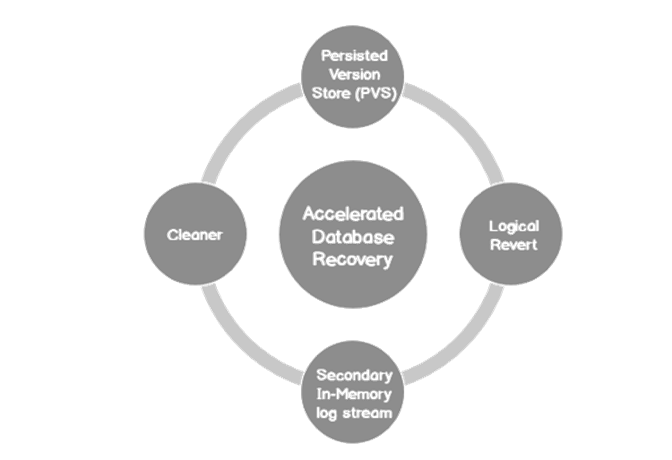

In [ ]:
--Habilitando o ADR
ALTER DATABASE [MyDatabase] SET ACCELERATED_DATABASE_RECOVERY = ON;
GO

--Defininfo o filegroup da PVS
ALTER DATABASE [MyDatabase] SET ACCELERATED_DATABASE_RECOVERY = ON
(PERSISTENT_VERSION_STORE_FILEGROUP = [VersionStoreFG])

--Desabilitando o ADR
ALTER DATABASE [MyDatabase] SET ACCELERATED_DATABASE_RECOVERY = OFF;
GO

--Alterando o filegroup do PVS depois de criado
--1) Parar o ADR
ALTER DATABASE [MyDatabase] SET ACCELERATED_DATABASE_RECOVERY = OFF;
GO

--2) Aguardar que todas as versões do PVS sejam excluidas
EXEC sys.sp_persistent_version_cleanup [database name]

SELECT DB_Name(database_id), persistent_version_store_size_kb 
FROM sys.dm_tran_persistent_version_store_stats where database_id = [MyDatabaseID]

--3) Iniciar o ADR selecionando o novo filegroup
ALTER DATABASE [MyDatabase] SET ACCELERATED_DATABASE_RECOVERY = ON
(PERSISTENT_VERSION_STORE_FILEGROUP = [VersionStoreFG])


--Testando o ADR
USE AdventureWorks2012
GO
CREATE TABLE Pessoa (CodCli INT IDENTITY(1,1), 
Nome VARCHAR(100), 
SobreNome VARCHAR(100))
GO
INSERT INTO Pessoa
SELECT Person.Person.FirstName, Person.Person.LastName 
FROM Person.Person
GO 2000

--Executar o update por alguns minutos e FORÇAR A PARADA DO SQL SERVER
UPDATE Pessoa
SET Nome = 'Maria'

In [ ]:
--Monitorar o tempo de recovery
DECLARE @DBName VARCHAR(64) = 'Warehouse'

DECLARE @ErrorLog AS TABLE([LogDate] CHAR(24), [ProcessInfo] VARCHAR(64), [TEXT] VARCHAR(MAX))

INSERT INTO @ErrorLog
EXEC master..sp_readerrorlog 0, 1, 'Recovery of database', @DBName

INSERT INTO @ErrorLog
EXEC master..sp_readerrorlog 0, 1, 'Recovery completed', @DBName

SELECT TOP 1
    @DBName AS [DBName]
   ,[LogDate]
   ,CASE
      WHEN SUBSTRING([TEXT],10,1) = 'c'
      THEN '100%'
      ELSE SUBSTRING([TEXT], CHARINDEX(') is ', [TEXT]) + 4,CHARINDEX(' complete (', [TEXT]) - CHARINDEX(') is ', [TEXT]) - 4)
      END AS PercentComplete
   ,CASE
      WHEN SUBSTRING([TEXT],10,1) = 'c'
      THEN 0
      ELSE CAST(SUBSTRING([TEXT], CHARINDEX('approximately', [TEXT]) + 13,CHARINDEX(' seconds remain', [TEXT]) - CHARINDEX('approximately', [TEXT]) - 13) AS FLOAT)/60.0
      END AS MinutesRemaining
   ,CASE
      WHEN SUBSTRING([TEXT],10,1) = 'c'
      THEN 0
      ELSE CAST(SUBSTRING([TEXT], CHARINDEX('approximately', [TEXT]) + 13,CHARINDEX(' seconds remain', [TEXT]) - CHARINDEX('approximately', [TEXT]) - 13) AS FLOAT)/60.0/60.0
      END AS HoursRemaining
   ,[TEXT]
FROM @ErrorLog ORDER BY CAST([LogDate] as datetime) DESC, [MinutesRemaining]

## <u>Checkpoint Indireto</u>

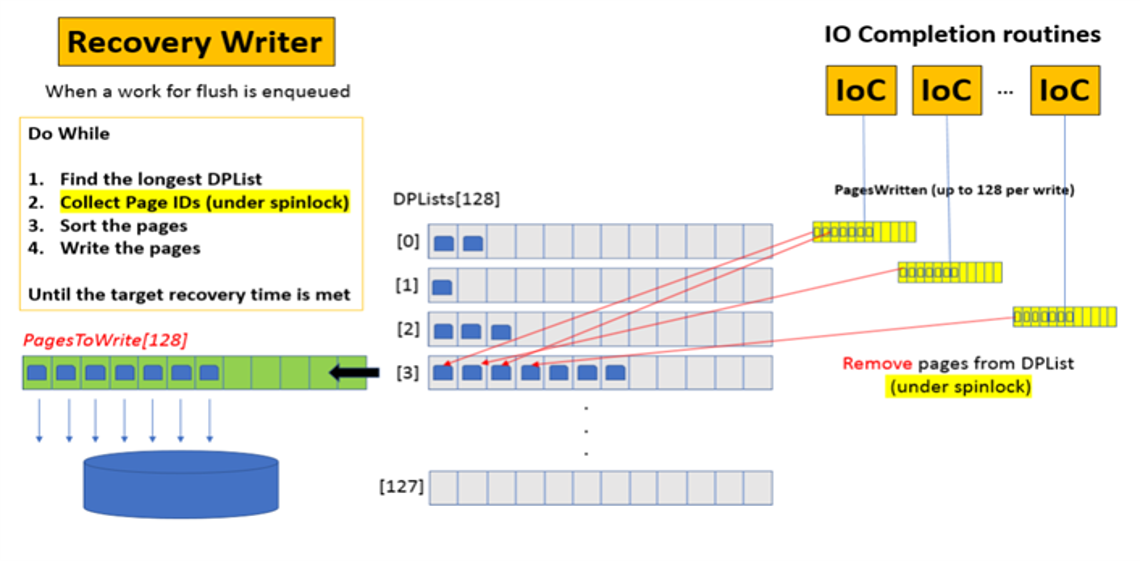

In [ ]:
--Monitorando as operações de CHECKPOINT
SELECT [Current LSN], 
       Operation, 
       Context, 
       LogBlockGeneration, 
       [Checkpoint Begin], 
       [Checkpoint End], 
       Description, 
       [Log Record]
FROM ::fn_dblog(NULL, NULL)
WHERE [Operation] LIKE '%CKPT';

--Monitorando o CHECKPOINT INDIRETO
SELECT map_value, 
       map_key, 
       name
FROM sys.dm_xe_map_values
WHERE map_value LIKE('DirtyPageList');

--Sessão de Extended Evernts para monitorar CHECKPOINT INDIRETO
CREATE EVENT SESSION spin_lock_backoff ON SERVER ADD EVENT sqlos.spinlock_backoff(ACTION(package0.callstack) WHERE type = 100) --Map value for DirtyPageList from previous query
ADD TARGET package0.asynchronous_bucketizer(SET filtering_event_name = 'sqlos.spinlock_backoff', source_type = 1, source = 'package0.callstack') WITH
(MAX_MEMORY = 50 MB, MEMORY_PARTITION_MODE = PER_NODE
);

--Habilitando a sessão de monitoração
ALTER EVENT SESSION spin_lock_backoff ON SERVER STATE = START;
SELECT *
FROM sys.dm_xe_sessions
WHERE name = 'spin_lock_backoff';

--Listando os eventos de CHECKPOINT INDIRETO
WAITFOR DELAY '00:01:00';
SELECT event_session_address, 
       target_name, 
       execution_count, 
       CAST(target_data AS XML)
FROM sys.dm_xe_session_targets xst
     INNER JOIN sys.dm_xe_sessions xs ON(xst.event_session_address = xs.address)
WHERE xs.name = 'spin_lock_backoff';

--Desabilitando a sessão de monitoração
ALTER EVENT SESSION spin_lock_backoff ON SERVER STATE = STOP;
DROP EVENT SESSION spin_lock_backoff ON SERVER

## <u>SQLOS - Schedulers</u>

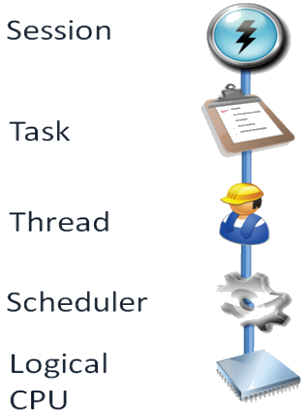

In [1]:
--Listando os schedulers definidos para a instância
SELECT
    *
FROM
    sys.dm_os_schedulers

(16 rows affected)

Total execution time: 00:00:00.121

scheduler_address,parent_node_id,scheduler_id,cpu_id,status,is_online,is_idle,preemptive_switches_count,context_switches_count,idle_switches_count,current_tasks_count,runnable_tasks_count,current_workers_count,active_workers_count,work_queue_count,pending_disk_io_count,load_factor,yield_count,last_timer_activity,failed_to_create_worker,active_worker_address,memory_object_address,task_memory_object_address,quantum_length_us,total_cpu_usage_ms,total_cpu_idle_capped_ms,total_scheduler_delay_ms,ideal_workers_limit
0x000001B148220040,0,0,0,VISIBLE ONLINE,1,0,263,1800,3034,5,0,10,5,0,0,5,6985,203788043,0,0x000001B139908160,0x000001B148050040,0x000001B148052040,4000,775,0,26,76
0x000001B148240040,0,1,1,VISIBLE ONLINE,1,1,870,2652,5271,6,0,11,5,0,0,4,11150,203788040,0,0x000001B13A3F0160,0x000001B14805A040,0x000001B14805C040,4000,350,0,45,78
0x000001B148260040,0,2,2,VISIBLE ONLINE,1,0,157,1192,908,5,0,10,5,0,0,7,3511,203788046,0,0x000001B148428160,0x000001B148062040,0x000001B148064040,4000,950,0,27,75
0x000001B148480040,0,3,3,VISIBLE ONLINE,1,1,332,1280,3160,3,0,10,3,0,0,3,7991,203788040,0,0x000001B13C102160,0x000001B14806A040,0x000001B14806C040,4000,821,0,31,76
0x000001B1484A0040,0,4,4,VISIBLE ONLINE,1,1,250,5166,4717,6,0,12,5,0,0,5,10256,203788040,0,0x000001B13E930160,0x000001B148072040,0x000001B148074040,4000,1127,0,55,77
0x000001B1484C0040,0,5,5,VISIBLE ONLINE,1,1,3390,7423,5190,3,0,10,3,0,0,3,14467,203788042,0,0x000001B10D776160,0x000001B14807A040,0x000001B14807C040,4000,2557,0,70,74
0x000001B1484E0040,0,6,6,VISIBLE ONLINE,1,1,126,526,6147,4,0,9,4,0,0,4,21493,203788040,0,0x000001B148734160,0x000001B148602040,0x000001B148604040,4000,48769,0,13,76
0x000001B148780040,0,7,7,VISIBLE ONLINE,1,1,107,1167,2450,7,0,12,5,0,0,4,5479,203788040,0,0x000001B1422AC160,0x000001B14860A040,0x000001B14860C040,4000,108,0,17,78
0x000001B1487A0040,0,1048578,0,HIDDEN ONLINE,1,0,0,0,3,1,0,1,1,0,0,1,6,201804273,0,0x000001B148644160,0x000001B14863E040,0x000001B148640040,4000,0,0,0,2
0x000001B1489A0040,64,1048576,0,VISIBLE ONLINE (DAC),1,1,4,9,9,2,0,3,1,0,0,0,16,203605101,0,0x000001B148648160,0x000001B148820040,0x000001B148822040,4000,4,0,0,5


## **<u>ThreadPool Starvation</u>**

Simulando um cenário no qual não temos mais conexões disponiveis para acessar o SQL Server

In [ ]:
--Reduzindo manualmente a quantidade de threads permitidas no SQL Server
EXEC sys.sp_configure N'max worker threads', N'128'
GO
RECONFIGURE
GO

In [ ]:
--Criando um banco e dados de testes
USE master
GO
 
CREATE DATABASE ThreadPoolWaits
GO
 
USE ThreadPoolWaits
GO
 
--Criando uma tabela de teste
CREATE TABLE [SomeCrazyUniqueTableName_6EFF088F-443B-4EBC-A4C7-9FC146D2EE49]
(
	[MyUniqueColumnName1_F67DAC4A-C202-49BB-829A-071130BF1160] INT IDENTITY(1, 1) NOT NULL PRIMARY KEY,
	[MyUniqueColumnName2_438B7184-B476-48A4-B5FA-DC34B99FA0A4] INT
)
GO
 
--Inserindo um registro na tabela criada anteriormente
INSERT INTO [SomeCrazyUniqueTableName_6EFF088F-443B-4EBC-A4C7-9FC146D2EE49]
VALUES (1)
GO

In [ ]:
--Criando uma stored procedure para realizar operações de leitura na tabela de teste
CREATE
PROCEDURE MyCustomUniqueStoredProcedureName_ReadWorkload
AS
BEGIN
	SELECT * FROM [SomeCrazyUniqueTableName_6EFF088F-443B-4EBC-A4C7-9FC146D2EE49]
END
GO

In [ ]:
--Iniciando uma transação que não terá COMMIT
BEGIN TRANSACTION
	UPDATE [SomeCrazyUniqueTableName_6EFF088F-443B-4EBC-A4C7-9FC146D2EE49] WITH (TABLOCKX)
		SET [MyUniqueColumnName2_438B7184-B476-48A4-B5FA-DC34B99FA0A4] = 2
GO

In [ ]:
--Executar a procedure em uma outra sessão utilizando o QUERYSTRESS (600 iterações)
EXEC MyCustomUniqueStoredProcedureName_ReadWorkload
GO

In [ ]:
--Verificando o cenário de falta de threads
SELECT
	r.command,
	r.sql_handle,
	r.plan_handle,
	r.wait_type,
	r.wait_resource,
	r.wait_time,
	r.session_id,
	r.blocking_session_id
FROM sys.dm_exec_requests r INNER JOIN sys.dm_exec_sessions s ON r.session_id = s.session_id
WHERE s.is_user_process = 1
GO